In [ ]:

def metric_perturbation_convergence_experiment(
    n=5,
    num_generators=None,
    data_size=int(1e5),
    batch_size=1024,
    epochs=400,
    lr=1e-2,
    device="cuda:0",
    num_trials=20,
    patience=10,
    show_generators=True
):
    if num_generators is None:
        num_generators = n * (n - 1) // 2
    norms = []
    epochs_to_converge = []
    
    for trial in range(num_trials):
        # Sample perturbation
        perturb = -2 * torch.rand(n)
        perturb_values = perturb.tolist()
        M_diag = torch.tensor([1 + val for val in perturb_values], device=device)
        M = torch.diag(M_diag)
        norm_perturb = torch.norm(M_diag - 1).item()
        var_names = [chr(ord('a') + i) for i in range(n)]
        perturb_str = ", ".join([f"{name}: {val:.3f}" for name, val in zip(var_names, perturb_values)])
        
        print(f"\nTrial {trial+1}/{num_trials}")
        print(f" Perturbation ({', '.join(var_names)}): {perturb_str}")
        print(f" Metric diagonal: {[round(val.item(), 3) for val in M_diag]}")
        print(f" Norm of perturbation: {norm_perturb:.4f}")
        
        def psi(x):
            return torch.sum((x @ M) * x, dim=1)
        
        data = torch.randn(data_size, n).to(device)
        model_symmetry = GroupLatent(num_features=n, num_generators=num_generators).to(device)
        optimiser_symmetry = torch.optim.Adam(model_symmetry.parameters(), lr=lr)
        criterion_mse = nn.MSELoss()
        orth_coeff = 1
        
        # Early stopping variables
        best_loss = float('inf')
        patience_counter = 0
        converged_epoch = epochs
        
        for epoch in range(epochs):
            index = torch.randperm(data.shape[0])
            closure_loss_epoch = 0
            
            for i in range(0, (data.shape[0] // batch_size) + 1):
                z = data[index[i * batch_size : (i + 1) * batch_size], :]
                if z.shape[0] == 0:
                    continue
                optimiser_symmetry.zero_grad()
                theta = [(2 * torch.rand(z.shape[0], device=device) - 1) for _ in range(num_generators)]
                z_prime = model_symmetry(theta=theta, x=z)
                closure_loss = criterion_mse(psi(z), psi(z_prime))
                orthogonal_loss = model_symmetry.orthogonal_loss_kon()
                loss_S = closure_loss + orth_coeff * orthogonal_loss
                loss_S.backward()
                optimiser_symmetry.step()
                closure_loss_epoch += closure_loss.item()
            
            closure_loss_epoch /= (data.shape[0] // batch_size) + 1
            
            # Early stopping: Convergence threshold
            if closure_loss_epoch < 1e-5:
                print(f"   Converged at epoch {epoch+1} (closure_loss < 1e-10)")
                converged_epoch = epoch + 1
                break
            
            # Early stopping: Patience-based
            
            
            # Progress printing
            if (epoch + 1) % 5 == 0 or closure_loss_epoch < 1e-10:
                print(f"    Epoch {epoch+1}: closure_loss = {closure_loss_epoch:.2e}")
        
        if converged_epoch == epochs:
            print(f"   Reached max epochs {epochs} (last closure_loss = {closure_loss_epoch:.2e})")
        
        # Display generators after each trial
        if show_generators:
            display_generators(model_symmetry, trial+1, n, norm_perturb, converged_epoch)
        
        norms.append(norm_perturb)
        epochs_to_converge.append(converged_epoch)
    
    print("\nSummary of all trials:")
    for i in range(num_trials):
        status = "-" if epochs_to_converge[i] < epochs else "-"
        print(f"  {status} Trial {i+1}: Norm = {norms[i]:.4f}, Epochs = {epochs_to_converge[i]}")
    
    # Enhanced plot with dynamic variable names
    plt.figure(figsize=(10, 6))
    colors = ['green' if ep < epochs else 'red' for ep in epochs_to_converge]
    plt.scatter(norms, epochs_to_converge, c=colors, alpha=0.7, s=60)
    
    var_names = [chr(ord('a') + i) for i in range(n)]
    plt.xlabel(f'Norm of ({", ".join(var_names)})')
    plt.ylabel('Epochs to Converge (<1e-10)')
    plt.title(f'Convergence Analysis: SO({n})')
    plt.grid(True, alpha=0.3)
    plt.show()
    



Trial 1/20
 Perturbation (a, b, c, d): a: -0.931, b: -0.644, c: -1.987, d: -1.440
 Metric diagonal: [0.069, 0.356, -0.987, -0.44]
 Norm of perturbation: 2.7020
    Epoch 5: closure_loss = 4.35e-02
    Epoch 10: closure_loss = 3.74e-03
    Epoch 15: closure_loss = 1.96e-03
    Epoch 20: closure_loss = 1.75e-03
    Epoch 25: closure_loss = 1.44e-03
    Epoch 30: closure_loss = 2.81e-03
    Epoch 35: closure_loss = 2.31e-03
    Epoch 40: closure_loss = 3.20e-03
    Epoch 45: closure_loss = 1.37e-03
    Epoch 50: closure_loss = 3.36e-03
    Epoch 55: closure_loss = 1.71e-03
    Epoch 60: closure_loss = 4.95e-03
    Epoch 65: closure_loss = 1.18e-03
    Epoch 70: closure_loss = 3.07e-03
    Epoch 75: closure_loss = 5.75e-04
    Epoch 80: closure_loss = 5.58e-04
    Epoch 85: closure_loss = 2.53e-05
   Converged at epoch 86 (closure_loss < 1e-10)


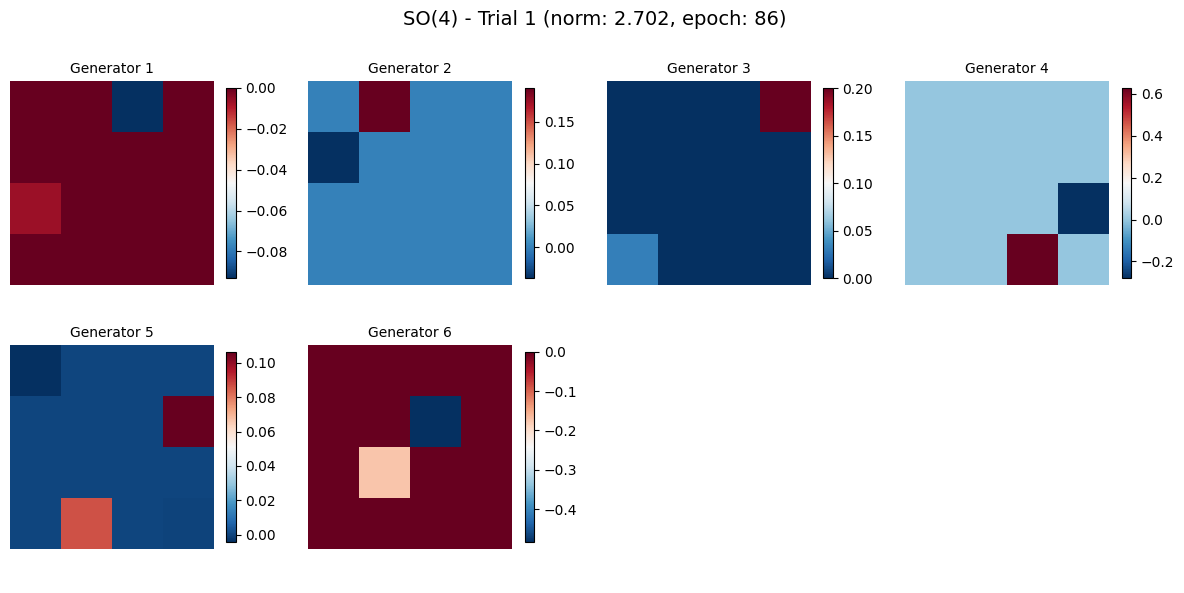


Trial 2/20
 Perturbation (a, b, c, d): a: -0.485, b: -0.760, c: -1.878, d: -1.273
 Metric diagonal: [0.515, 0.24, -0.878, -0.273]
 Norm of perturbation: 2.4414
    Epoch 5: closure_loss = 1.41e-01
    Epoch 10: closure_loss = 8.61e-03
    Epoch 15: closure_loss = 4.57e-03
    Epoch 20: closure_loss = 2.40e-03
    Epoch 25: closure_loss = 3.43e-03
    Epoch 30: closure_loss = 5.27e-03
    Epoch 35: closure_loss = 2.65e-03
    Epoch 40: closure_loss = 6.65e-03
    Epoch 45: closure_loss = 4.40e-03
    Epoch 50: closure_loss = 5.06e-03
    Epoch 55: closure_loss = 3.22e-03
    Epoch 60: closure_loss = 4.20e-03
    Epoch 65: closure_loss = 4.38e-03
    Epoch 70: closure_loss = 7.26e-03
    Epoch 75: closure_loss = 2.39e-03
    Epoch 80: closure_loss = 2.54e-03
    Epoch 85: closure_loss = 2.11e-03
    Epoch 90: closure_loss = 7.93e-04
    Epoch 95: closure_loss = 1.08e-03
    Epoch 100: closure_loss = 3.73e-03
    Epoch 105: closure_loss = 2.72e-03
    Epoch 110: closure_loss = 3.15e-03
 

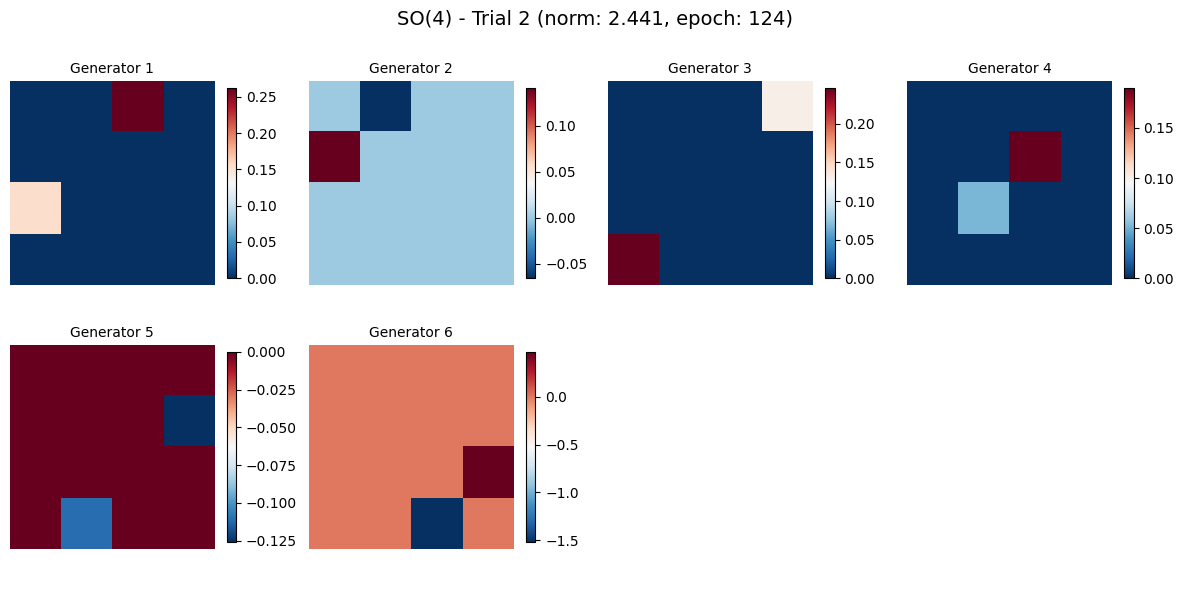


Trial 3/20
 Perturbation (a, b, c, d): a: -1.693, b: -0.327, c: -0.744, d: -1.187
 Metric diagonal: [-0.693, 0.673, 0.256, -0.187]
 Norm of perturbation: 2.2211
    Epoch 5: closure_loss = 9.17e-03
    Epoch 10: closure_loss = 1.97e-03
    Epoch 15: closure_loss = 7.90e-04
    Epoch 20: closure_loss = 1.23e-03
    Epoch 25: closure_loss = 1.27e-03
    Epoch 30: closure_loss = 1.31e-03
    Epoch 35: closure_loss = 1.25e-03
    Epoch 40: closure_loss = 2.71e-03
    Epoch 45: closure_loss = 1.05e-03
    Epoch 50: closure_loss = 9.03e-04
    Epoch 55: closure_loss = 2.26e-03
    Epoch 60: closure_loss = 1.55e-03
    Epoch 65: closure_loss = 1.91e-03
    Epoch 70: closure_loss = 1.33e-03
    Epoch 75: closure_loss = 1.38e-03
    Epoch 80: closure_loss = 1.48e-03
    Epoch 85: closure_loss = 2.08e-03
    Epoch 90: closure_loss = 2.55e-03
   Converged at epoch 95 (closure_loss < 1e-10)


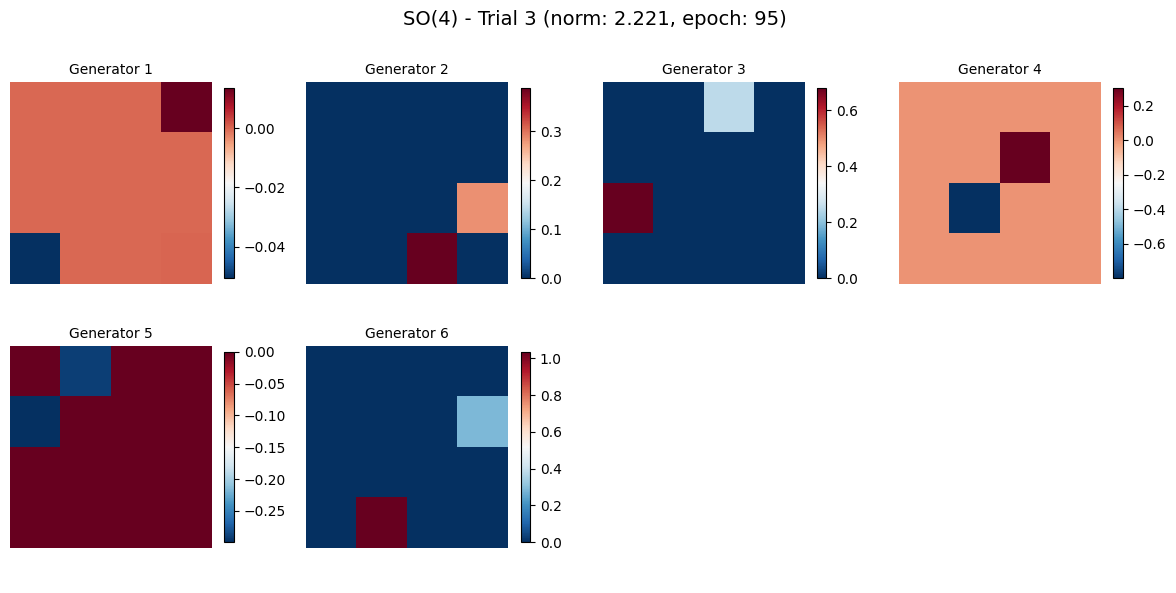


Trial 4/20
 Perturbation (a, b, c, d): a: -0.229, b: -0.536, c: -1.080, d: -1.469
 Metric diagonal: [0.771, 0.464, -0.08, -0.469]
 Norm of perturbation: 1.9137
    Epoch 5: closure_loss = 3.49e-03
    Epoch 10: closure_loss = 3.49e-03
    Epoch 15: closure_loss = 5.89e-03
    Epoch 20: closure_loss = 5.21e-03
    Epoch 25: closure_loss = 8.36e-03
    Epoch 30: closure_loss = 5.06e-03
    Epoch 35: closure_loss = 8.10e-03
    Epoch 40: closure_loss = 3.66e-03
    Epoch 45: closure_loss = 6.27e-03
    Epoch 50: closure_loss = 6.02e-03
    Epoch 55: closure_loss = 2.28e-03
    Epoch 60: closure_loss = 8.55e-03
    Epoch 65: closure_loss = 8.64e-03
    Epoch 70: closure_loss = 1.10e-02
    Epoch 75: closure_loss = 6.50e-03
    Epoch 80: closure_loss = 8.87e-03
    Epoch 85: closure_loss = 2.65e-03
    Epoch 90: closure_loss = 4.71e-03
    Epoch 95: closure_loss = 3.74e-04
    Epoch 100: closure_loss = 8.92e-04
    Epoch 105: closure_loss = 3.44e-04
    Epoch 110: closure_loss = 8.28e-04
 

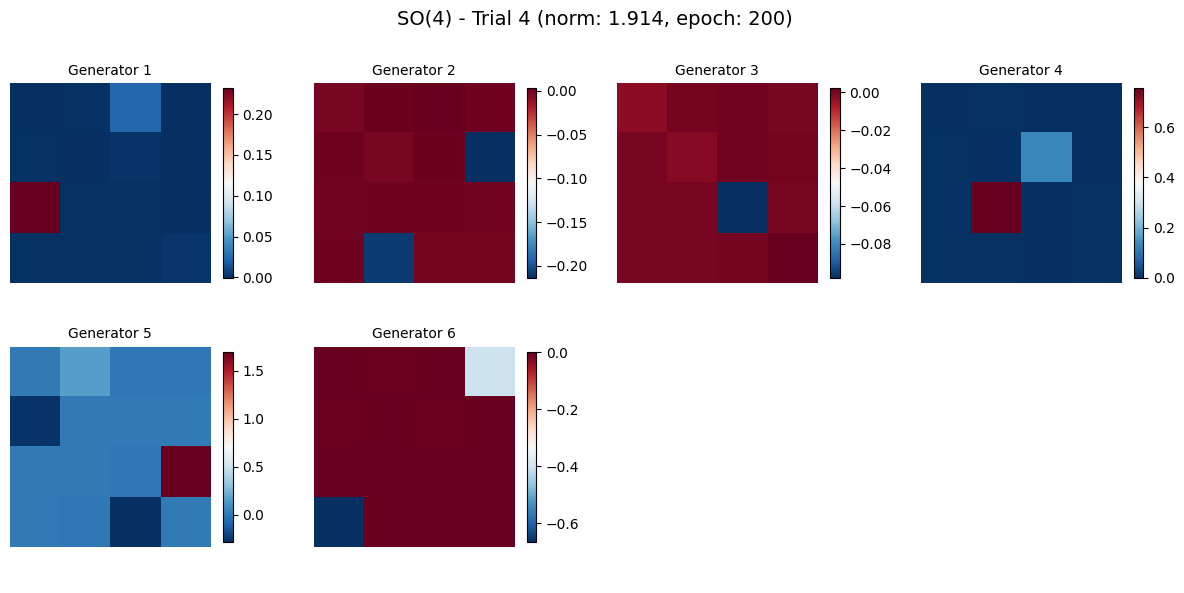


Trial 5/20
 Perturbation (a, b, c, d): a: -0.797, b: -1.052, c: -0.933, d: -0.533
 Metric diagonal: [0.203, -0.052, 0.067, 0.467]
 Norm of perturbation: 1.7022
    Epoch 5: closure_loss = 2.20e-03
    Epoch 10: closure_loss = 1.81e-04
    Epoch 15: closure_loss = 1.74e-04
    Epoch 20: closure_loss = 2.57e-04
    Epoch 25: closure_loss = 2.50e-04
    Epoch 30: closure_loss = 3.31e-04
    Epoch 35: closure_loss = 3.95e-04
    Epoch 40: closure_loss = 3.98e-04
    Epoch 45: closure_loss = 2.26e-04
    Epoch 50: closure_loss = 3.45e-04
    Epoch 55: closure_loss = 5.20e-04
    Epoch 60: closure_loss = 4.95e-04
    Epoch 65: closure_loss = 3.50e-04
    Epoch 70: closure_loss = 3.15e-04
    Epoch 75: closure_loss = 3.69e-04
    Epoch 80: closure_loss = 2.98e-04
    Epoch 85: closure_loss = 4.86e-04
    Epoch 90: closure_loss = 3.88e-04
    Epoch 95: closure_loss = 5.77e-04
    Epoch 100: closure_loss = 4.37e-04
    Epoch 105: closure_loss = 3.57e-04
    Epoch 110: closure_loss = 4.23e-04
 

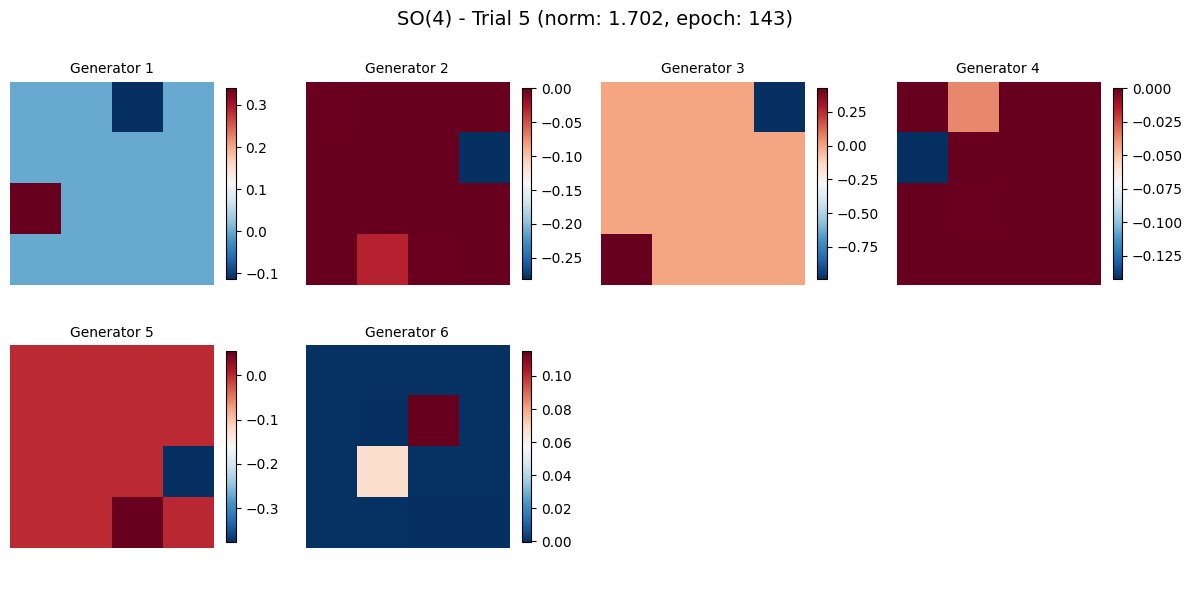


Trial 6/20
 Perturbation (a, b, c, d): a: -0.658, b: -0.372, c: -1.608, d: -1.022
 Metric diagonal: [0.342, 0.628, -0.608, -0.022]
 Norm of perturbation: 2.0501
    Epoch 5: closure_loss = 4.99e-03
    Epoch 10: closure_loss = 4.31e-03
    Epoch 15: closure_loss = 4.11e-03
    Epoch 20: closure_loss = 4.53e-03
    Epoch 25: closure_loss = 4.31e-03
    Epoch 30: closure_loss = 4.37e-03
    Epoch 35: closure_loss = 4.26e-03
    Epoch 40: closure_loss = 4.40e-03
    Epoch 45: closure_loss = 3.82e-03
    Epoch 50: closure_loss = 7.91e-03
    Epoch 55: closure_loss = 2.51e-03
    Epoch 60: closure_loss = 8.86e-03
    Epoch 65: closure_loss = 9.62e-03
    Epoch 70: closure_loss = 6.99e-05
    Epoch 75: closure_loss = 5.08e-05
    Epoch 80: closure_loss = 5.98e-05
    Epoch 85: closure_loss = 3.53e-05
    Epoch 90: closure_loss = 1.04e-04
    Epoch 95: closure_loss = 1.75e-04
    Epoch 100: closure_loss = 6.43e-05
    Epoch 105: closure_loss = 1.90e-04
    Epoch 110: closure_loss = 2.99e-04


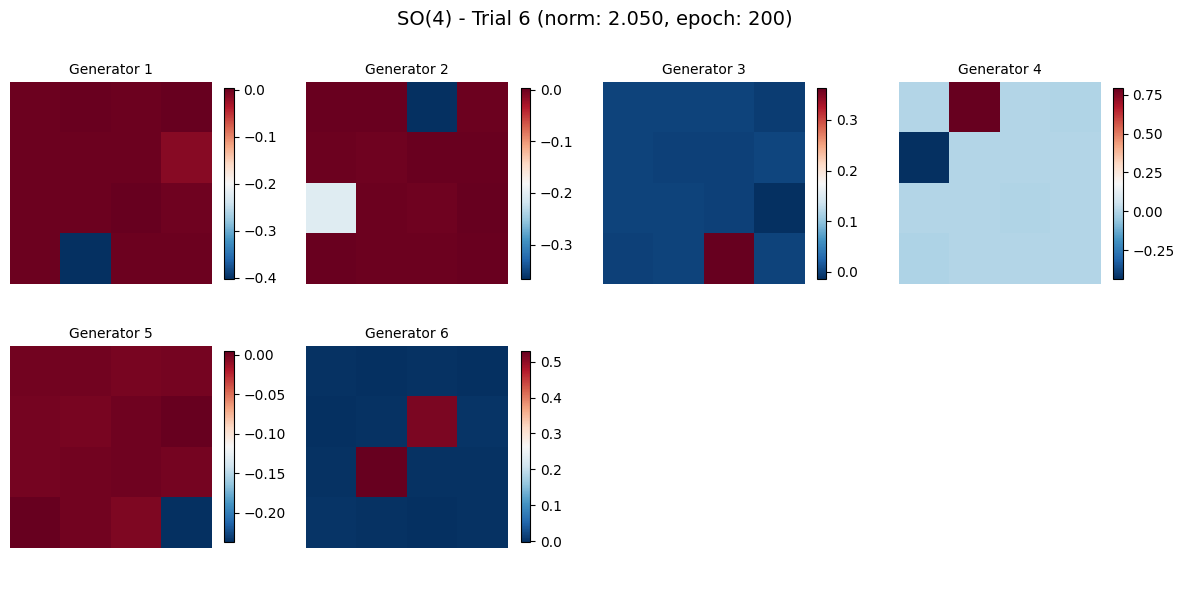


Trial 7/20
 Perturbation (a, b, c, d): a: -0.438, b: -1.909, c: -1.142, d: -0.745
 Metric diagonal: [0.562, -0.909, -0.142, 0.255]
 Norm of perturbation: 2.3868
    Epoch 5: closure_loss = 7.21e-03
    Epoch 10: closure_loss = 1.93e-03
    Epoch 15: closure_loss = 1.68e-03
    Epoch 20: closure_loss = 2.50e-03
    Epoch 25: closure_loss = 2.08e-03
    Epoch 30: closure_loss = 3.16e-03
    Epoch 35: closure_loss = 1.96e-03
    Epoch 40: closure_loss = 2.48e-03
    Epoch 45: closure_loss = 2.26e-03
    Epoch 50: closure_loss = 1.94e-03
    Epoch 55: closure_loss = 2.29e-03
    Epoch 60: closure_loss = 2.40e-03
    Epoch 65: closure_loss = 1.68e-03
    Epoch 70: closure_loss = 2.83e-03
    Epoch 75: closure_loss = 2.17e-03
    Epoch 80: closure_loss = 2.85e-03
    Epoch 85: closure_loss = 2.63e-03
    Epoch 90: closure_loss = 2.79e-03
    Epoch 95: closure_loss = 1.56e-03
    Epoch 100: closure_loss = 1.50e-03
    Epoch 105: closure_loss = 1.76e-03
    Epoch 110: closure_loss = 1.15e-03


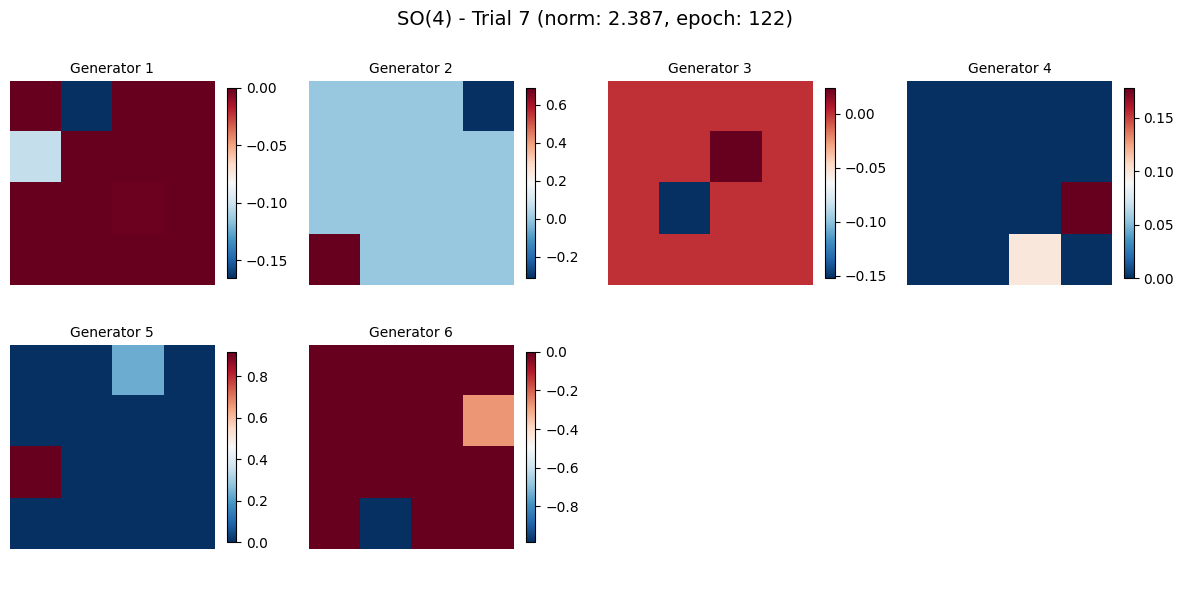


Trial 8/20
 Perturbation (a, b, c, d): a: -0.292, b: -0.583, c: -0.969, d: -1.790
 Metric diagonal: [0.708, 0.417, 0.031, -0.79]
 Norm of perturbation: 2.1371
    Epoch 5: closure_loss = 6.43e-03
    Epoch 10: closure_loss = 3.13e-03
   Converged at epoch 15 (closure_loss < 1e-10)


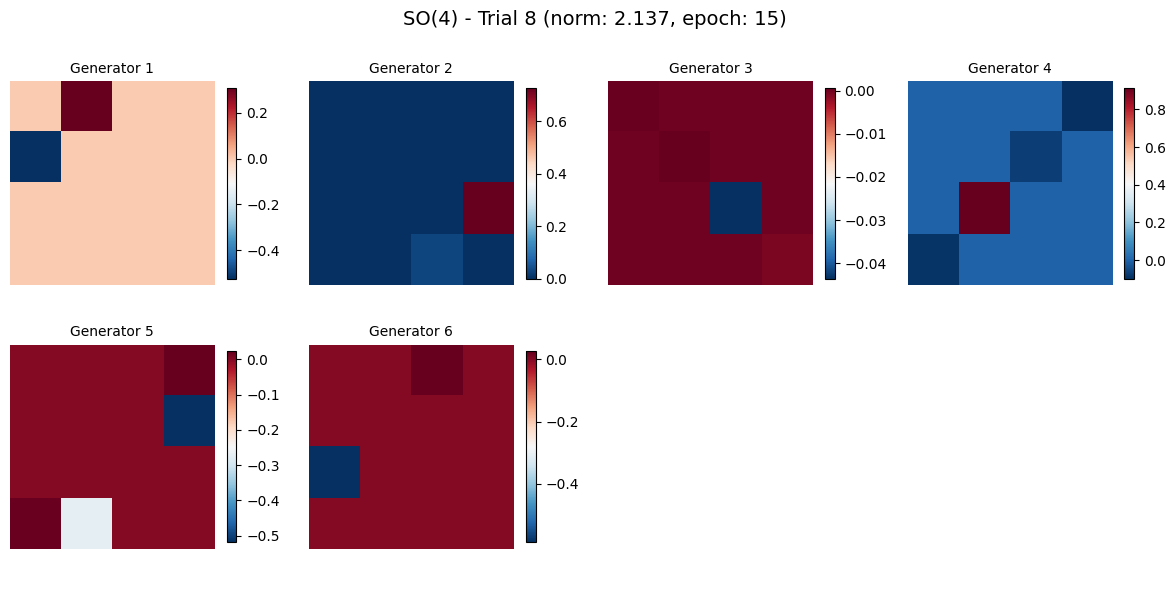


Trial 9/20
 Perturbation (a, b, c, d): a: -1.627, b: -1.939, c: -1.769, d: -0.893
 Metric diagonal: [-0.627, -0.939, -0.769, 0.107]
 Norm of perturbation: 3.2146
    Epoch 5: closure_loss = 1.06e-02
    Epoch 10: closure_loss = 1.08e-02
    Epoch 15: closure_loss = 5.66e-03
    Epoch 20: closure_loss = 3.64e-03
    Epoch 25: closure_loss = 5.69e-03
    Epoch 30: closure_loss = 5.64e-03
    Epoch 35: closure_loss = 7.18e-03
    Epoch 40: closure_loss = 1.23e-02
    Epoch 45: closure_loss = 7.63e-03
    Epoch 50: closure_loss = 5.16e-03
    Epoch 55: closure_loss = 4.47e-03
    Epoch 60: closure_loss = 9.80e-03
    Epoch 65: closure_loss = 7.46e-04
    Epoch 70: closure_loss = 5.20e-04
    Epoch 75: closure_loss = 5.14e-04
    Epoch 80: closure_loss = 5.29e-04
    Epoch 85: closure_loss = 6.96e-04
    Epoch 90: closure_loss = 1.24e-03
    Epoch 95: closure_loss = 7.21e-04
    Epoch 100: closure_loss = 1.59e-03
    Epoch 105: closure_loss = 3.94e-04
    Epoch 110: closure_loss = 8.99e-04

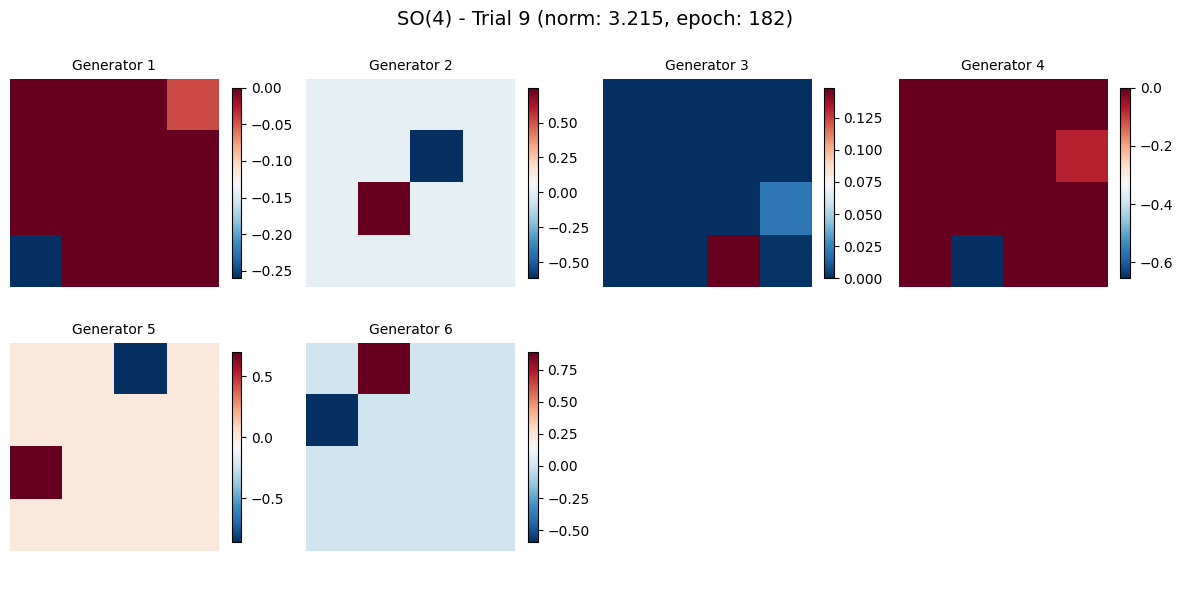


Trial 10/20
 Perturbation (a, b, c, d): a: -1.037, b: -0.686, c: -1.767, d: -0.148
 Metric diagonal: [-0.037, 0.314, -0.767, 0.852]
 Norm of perturbation: 2.1652
    Epoch 5: closure_loss = 4.63e-03
    Epoch 10: closure_loss = 4.16e-03
    Epoch 15: closure_loss = 3.20e-03
    Epoch 20: closure_loss = 7.25e-03
    Epoch 25: closure_loss = 1.62e-03
    Epoch 30: closure_loss = 1.84e-03
    Epoch 35: closure_loss = 3.77e-03
    Epoch 40: closure_loss = 6.28e-03
    Epoch 45: closure_loss = 5.06e-03
    Epoch 50: closure_loss = 8.41e-03
    Epoch 55: closure_loss = 4.84e-03
    Epoch 60: closure_loss = 3.36e-04
    Epoch 65: closure_loss = 1.54e-04
    Epoch 70: closure_loss = 3.07e-04
    Epoch 75: closure_loss = 1.17e-04
    Epoch 80: closure_loss = 2.03e-04
    Epoch 85: closure_loss = 1.82e-04
    Epoch 90: closure_loss = 1.85e-04
    Epoch 95: closure_loss = 2.55e-04
    Epoch 100: closure_loss = 1.59e-04
    Epoch 105: closure_loss = 2.78e-04
    Epoch 110: closure_loss = 1.31e-04

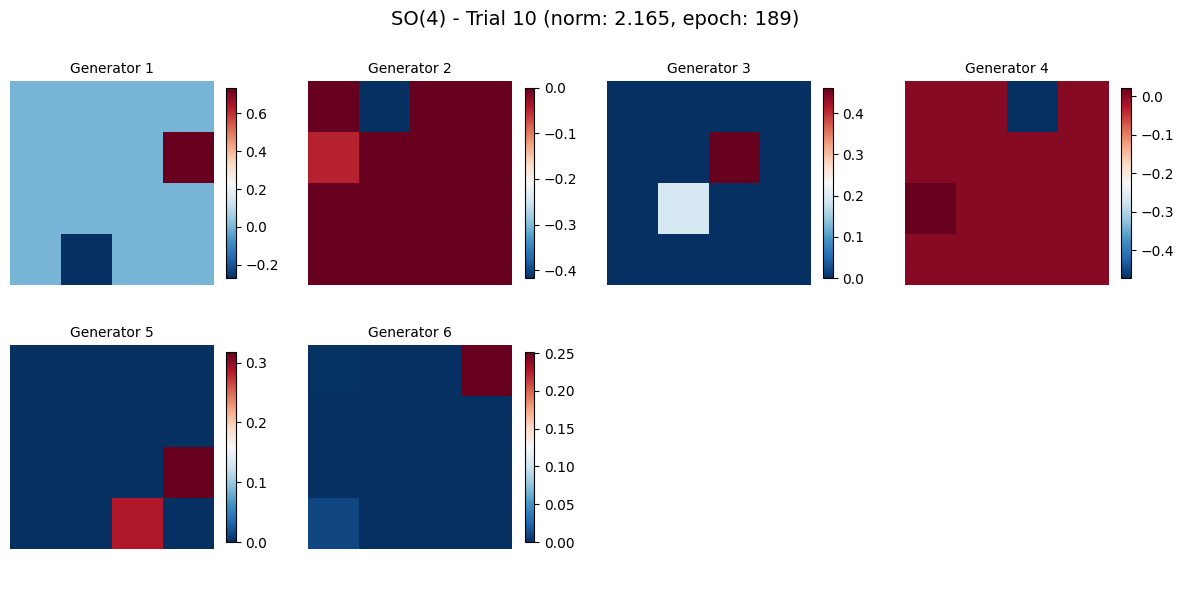


Trial 11/20
 Perturbation (a, b, c, d): a: -0.848, b: -1.614, c: -0.509, d: -1.241
 Metric diagonal: [0.152, -0.614, 0.491, -0.241]
 Norm of perturbation: 2.2634
    Epoch 5: closure_loss = 6.97e-04
    Epoch 10: closure_loss = 1.83e-03
    Epoch 15: closure_loss = 2.50e-03
    Epoch 20: closure_loss = 1.55e-03
    Epoch 25: closure_loss = 2.47e-03
    Epoch 30: closure_loss = 7.27e-04
    Epoch 35: closure_loss = 3.49e-03
    Epoch 40: closure_loss = 1.72e-03
    Epoch 45: closure_loss = 1.31e-03
    Epoch 50: closure_loss = 1.46e-03
    Epoch 55: closure_loss = 3.14e-03
    Epoch 60: closure_loss = 1.81e-03
    Epoch 65: closure_loss = 2.22e-03
    Epoch 70: closure_loss = 2.05e-03
    Epoch 75: closure_loss = 7.15e-04
    Epoch 80: closure_loss = 2.17e-03
    Epoch 85: closure_loss = 1.00e-03
    Epoch 90: closure_loss = 1.15e-03
    Epoch 95: closure_loss = 1.53e-03
    Epoch 100: closure_loss = 1.32e-03
    Epoch 105: closure_loss = 1.16e-03
    Epoch 110: closure_loss = 4.03e-04

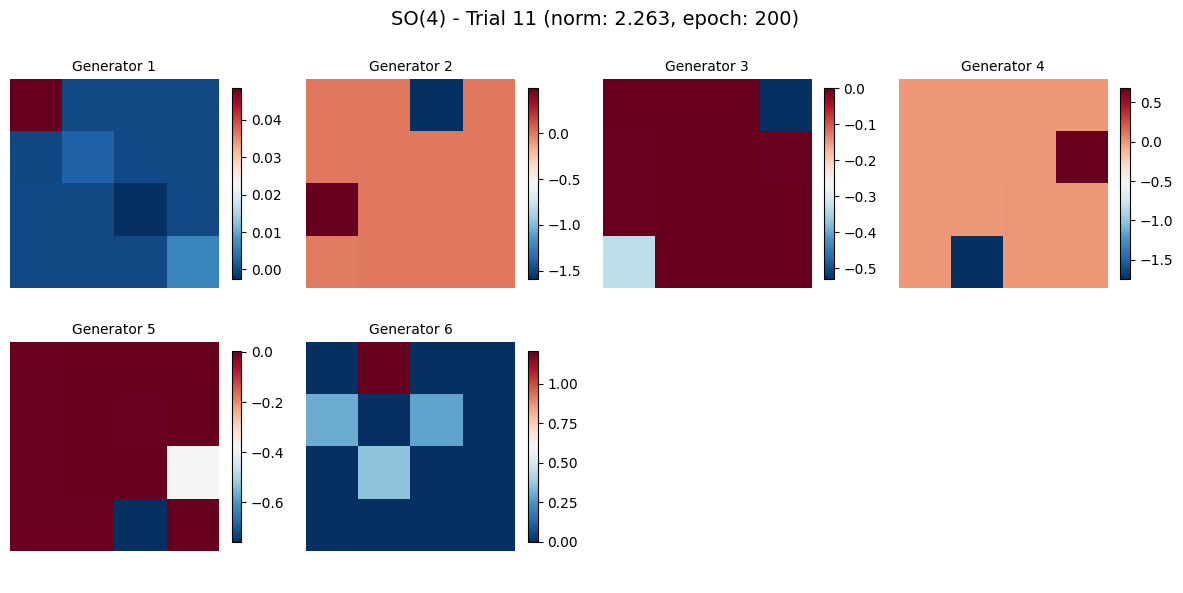


Trial 12/20
 Perturbation (a, b, c, d): a: -1.848, b: -0.102, c: -1.951, d: -0.948
 Metric diagonal: [-0.848, 0.898, -0.951, 0.052]
 Norm of perturbation: 2.8518
    Epoch 5: closure_loss = 1.99e-02
    Epoch 10: closure_loss = 1.43e-02
    Epoch 15: closure_loss = 2.06e-02
    Epoch 20: closure_loss = 1.24e-02
    Epoch 25: closure_loss = 6.92e-03
    Epoch 30: closure_loss = 2.71e-03
    Epoch 35: closure_loss = 1.01e-02
    Epoch 40: closure_loss = 8.98e-03
    Epoch 45: closure_loss = 2.00e-04
    Epoch 50: closure_loss = 1.93e-04
    Epoch 55: closure_loss = 4.61e-04
    Epoch 60: closure_loss = 2.88e-04
    Epoch 65: closure_loss = 3.96e-04
    Epoch 70: closure_loss = 1.89e-04
    Epoch 75: closure_loss = 2.11e-04
    Epoch 80: closure_loss = 1.99e-04
    Epoch 85: closure_loss = 1.85e-04
    Epoch 90: closure_loss = 2.52e-04
    Epoch 95: closure_loss = 7.29e-04
    Epoch 100: closure_loss = 2.91e-04
    Epoch 105: closure_loss = 3.97e-04
    Epoch 110: closure_loss = 4.42e-04

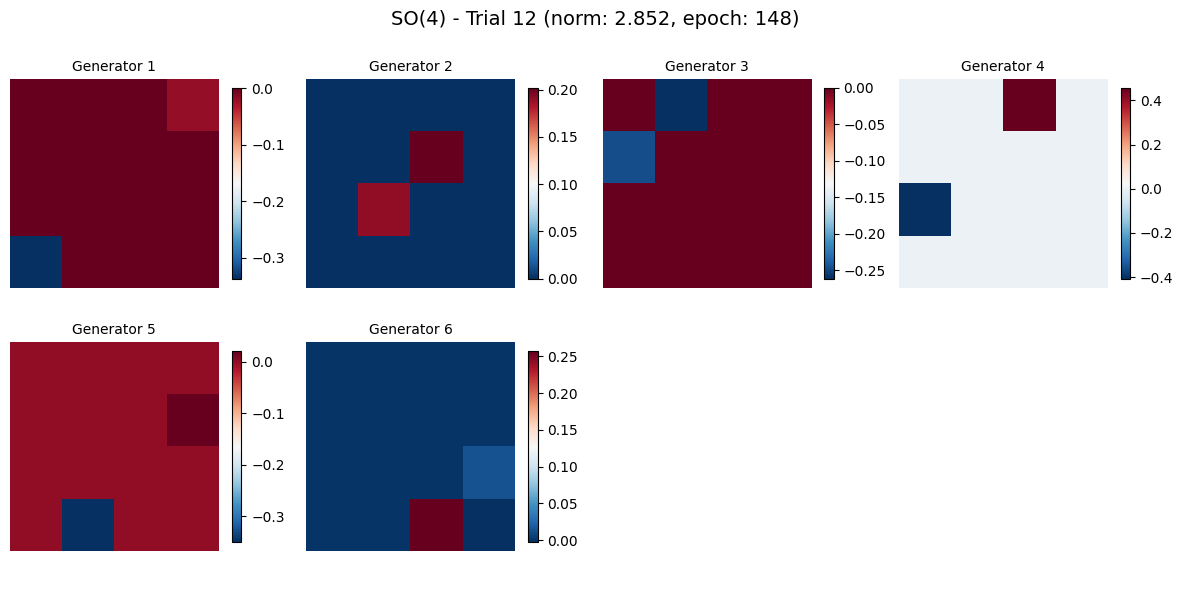


Trial 13/20
 Perturbation (a, b, c, d): a: -0.478, b: -0.557, c: -0.453, d: -0.539
 Metric diagonal: [0.522, 0.443, 0.547, 0.461]
 Norm of perturbation: 1.0166
    Epoch 5: closure_loss = 6.28e-02
    Epoch 10: closure_loss = 4.43e-03
    Epoch 15: closure_loss = 4.37e-03
    Epoch 20: closure_loss = 2.51e-03
    Epoch 25: closure_loss = 4.16e-03
    Epoch 30: closure_loss = 4.94e-03
    Epoch 35: closure_loss = 5.92e-03
    Epoch 40: closure_loss = 6.12e-03
    Epoch 45: closure_loss = 4.25e-03
    Epoch 50: closure_loss = 5.39e-03
    Epoch 55: closure_loss = 5.40e-03
    Epoch 60: closure_loss = 5.57e-03
    Epoch 65: closure_loss = 3.35e-03
    Epoch 70: closure_loss = 3.18e-03
    Epoch 75: closure_loss = 3.57e-03
    Epoch 80: closure_loss = 7.12e-03
    Epoch 85: closure_loss = 4.43e-03
    Epoch 90: closure_loss = 7.61e-03
    Epoch 95: closure_loss = 2.33e-03
    Epoch 100: closure_loss = 5.04e-03
    Epoch 105: closure_loss = 7.16e-03
   Converged at epoch 110 (closure_loss 

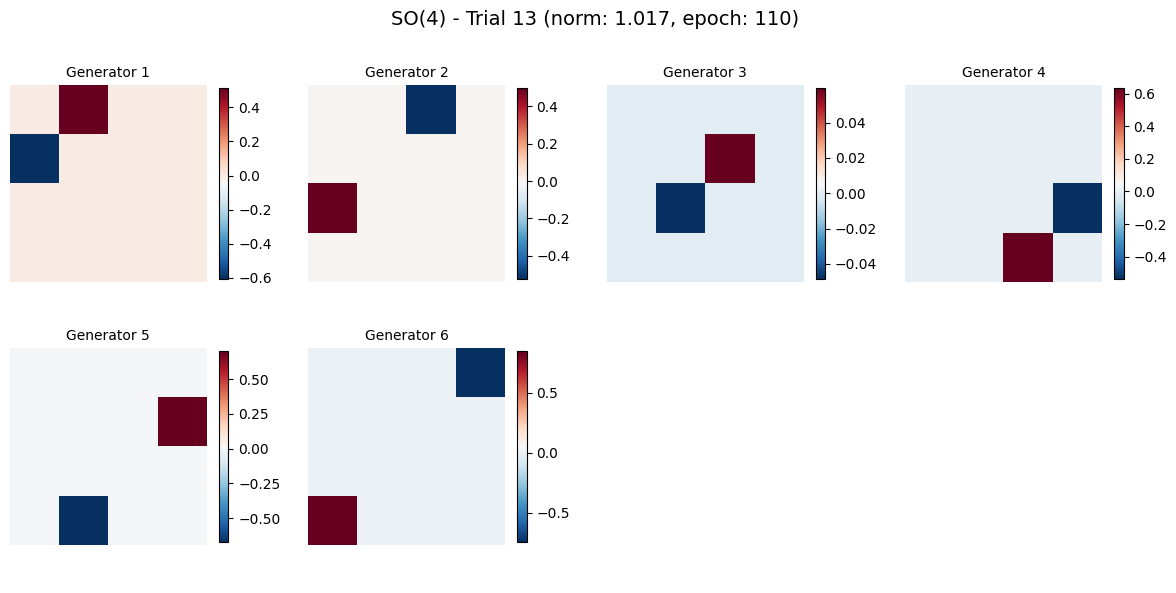


Trial 14/20
 Perturbation (a, b, c, d): a: -1.693, b: -1.147, c: -1.225, d: -0.203
 Metric diagonal: [-0.693, -0.147, -0.225, 0.797]
 Norm of perturbation: 2.3924
    Epoch 5: closure_loss = 1.34e-02
    Epoch 10: closure_loss = 1.80e-02
    Epoch 15: closure_loss = 1.31e-02
    Epoch 20: closure_loss = 1.79e-02
    Epoch 25: closure_loss = 1.00e-03
    Epoch 30: closure_loss = 1.62e-03
    Epoch 35: closure_loss = 1.74e-03
    Epoch 40: closure_loss = 2.29e-03
    Epoch 45: closure_loss = 2.70e-03
    Epoch 50: closure_loss = 6.77e-03
    Epoch 55: closure_loss = 1.74e-03
    Epoch 60: closure_loss = 2.34e-03
    Epoch 65: closure_loss = 2.18e-03
    Epoch 70: closure_loss = 3.68e-03
    Epoch 75: closure_loss = 4.56e-03
    Epoch 80: closure_loss = 1.64e-03
    Epoch 85: closure_loss = 3.00e-03
    Epoch 90: closure_loss = 8.47e-04
    Epoch 95: closure_loss = 9.85e-04
   Converged at epoch 97 (closure_loss < 1e-10)


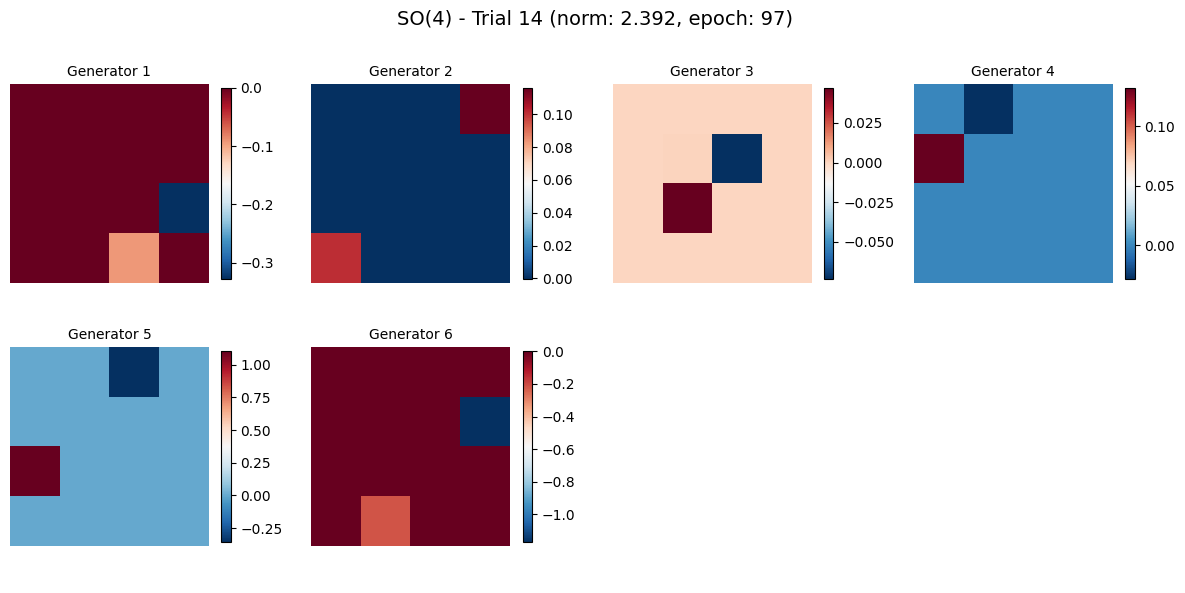


Trial 15/20
 Perturbation (a, b, c, d): a: -1.441, b: -0.926, c: -1.908, d: -0.611
 Metric diagonal: [-0.441, 0.074, -0.908, 0.389]
 Norm of perturbation: 2.6364
    Epoch 5: closure_loss = 1.25e-02
    Epoch 10: closure_loss = 4.18e-04
    Epoch 15: closure_loss = 1.92e-04
    Epoch 20: closure_loss = 6.79e-05
    Epoch 25: closure_loss = 1.70e-05
   Converged at epoch 27 (closure_loss < 1e-10)


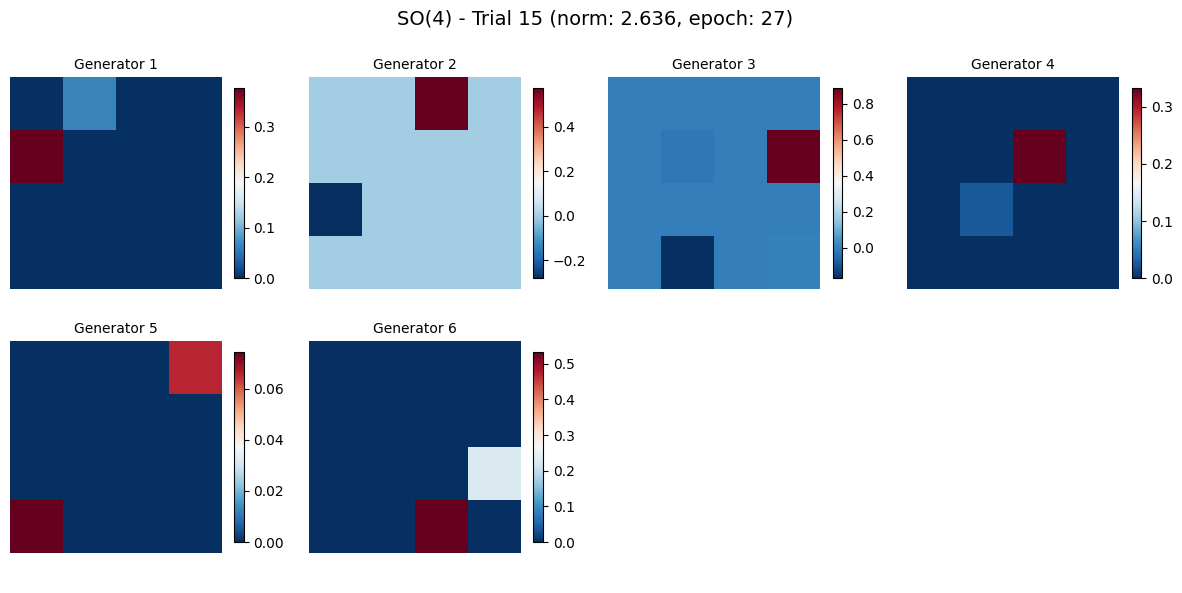


Trial 16/20
 Perturbation (a, b, c, d): a: -1.831, b: -0.584, c: -1.508, d: -0.312
 Metric diagonal: [-0.831, 0.416, -0.508, 0.688]
 Norm of perturbation: 2.4626
    Epoch 5: closure_loss = 5.85e-03
    Epoch 10: closure_loss = 1.62e-03
    Epoch 15: closure_loss = 4.24e-03
    Epoch 20: closure_loss = 3.43e-03
    Epoch 25: closure_loss = 3.61e-03
    Epoch 30: closure_loss = 4.50e-03
    Epoch 35: closure_loss = 5.23e-03
    Epoch 40: closure_loss = 2.73e-03
    Epoch 45: closure_loss = 3.56e-03
    Epoch 50: closure_loss = 2.43e-03
    Epoch 55: closure_loss = 2.57e-03
    Epoch 60: closure_loss = 5.37e-03
    Epoch 65: closure_loss = 5.03e-03
   Converged at epoch 68 (closure_loss < 1e-10)


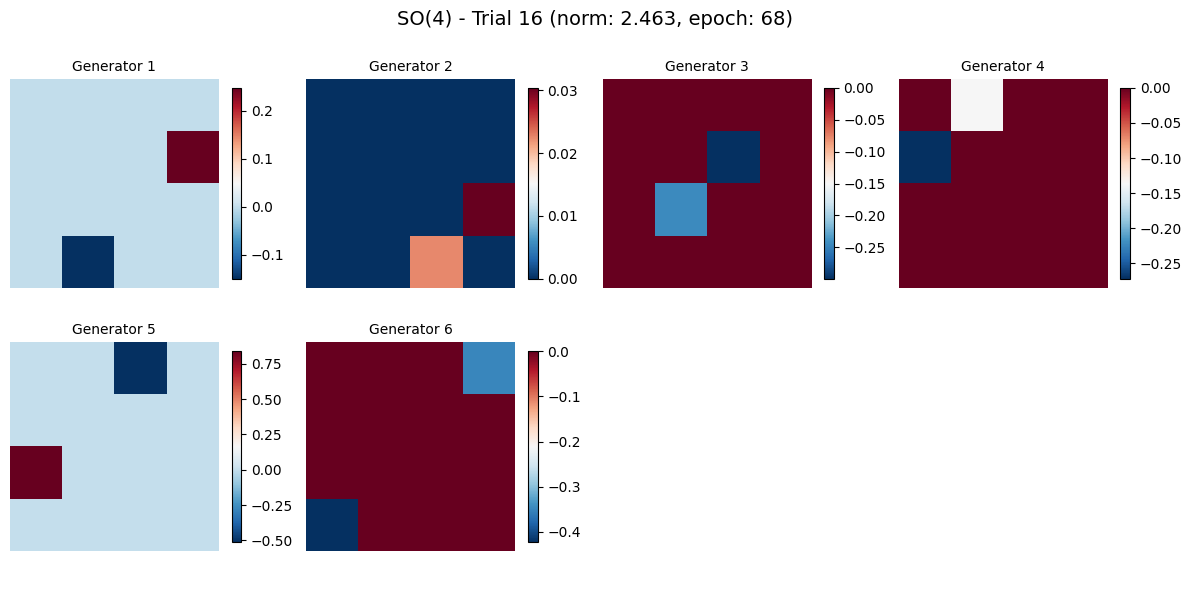


Trial 17/20
 Perturbation (a, b, c, d): a: -1.148, b: -1.536, c: -1.921, d: -0.002
 Metric diagonal: [-0.148, -0.536, -0.921, 0.998]
 Norm of perturbation: 2.7144
    Epoch 5: closure_loss = 1.56e-02
    Epoch 10: closure_loss = 9.28e-04
    Epoch 15: closure_loss = 1.98e-04
    Epoch 20: closure_loss = 3.67e-04
    Epoch 25: closure_loss = 1.77e-04
    Epoch 30: closure_loss = 9.75e-04
    Epoch 35: closure_loss = 5.15e-04
    Epoch 40: closure_loss = 1.49e-03
    Epoch 45: closure_loss = 5.34e-04
    Epoch 50: closure_loss = 7.26e-04
    Epoch 55: closure_loss = 1.75e-03
    Epoch 60: closure_loss = 1.22e-03
    Epoch 65: closure_loss = 1.61e-03
    Epoch 70: closure_loss = 1.52e-03
    Epoch 75: closure_loss = 8.01e-04
    Epoch 80: closure_loss = 9.68e-04
    Epoch 85: closure_loss = 6.42e-04
    Epoch 90: closure_loss = 2.71e-03
    Epoch 95: closure_loss = 2.82e-03
    Epoch 100: closure_loss = 1.11e-03
    Epoch 105: closure_loss = 1.12e-03
    Epoch 110: closure_loss = 2.33e-0

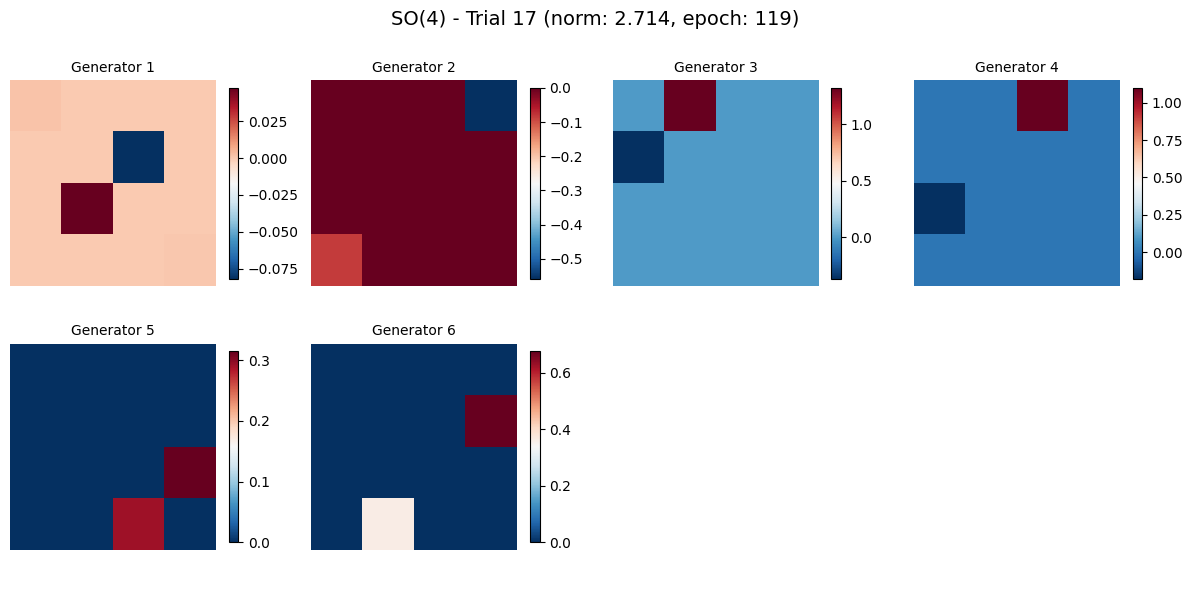


Trial 18/20
 Perturbation (a, b, c, d): a: -1.624, b: -1.301, c: -0.391, d: -1.275
 Metric diagonal: [-0.624, -0.301, 0.609, -0.275]
 Norm of perturbation: 2.4716
    Epoch 5: closure_loss = 5.31e-05
   Converged at epoch 6 (closure_loss < 1e-10)


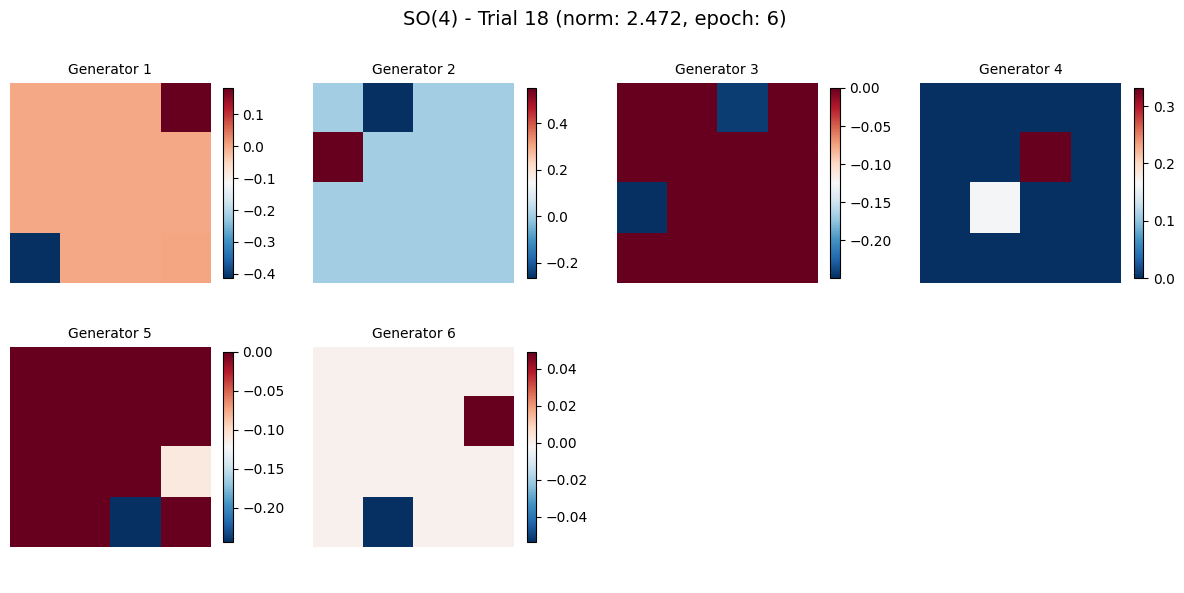


Trial 19/20
 Perturbation (a, b, c, d): a: -0.092, b: -0.144, c: -0.169, d: -0.681
 Metric diagonal: [0.908, 0.856, 0.831, 0.319]
 Norm of perturbation: 0.7227
    Epoch 5: closure_loss = 1.36e-01
    Epoch 10: closure_loss = 7.48e-03
    Epoch 15: closure_loss = 5.29e-04
    Epoch 20: closure_loss = 3.44e-04
    Epoch 25: closure_loss = 4.53e-04
    Epoch 30: closure_loss = 3.81e-04
    Epoch 35: closure_loss = 1.07e-03
    Epoch 40: closure_loss = 1.42e-03
    Epoch 45: closure_loss = 1.41e-03
    Epoch 50: closure_loss = 2.94e-03
    Epoch 55: closure_loss = 2.94e-03
    Epoch 60: closure_loss = 3.60e-03
    Epoch 65: closure_loss = 2.65e-03
    Epoch 70: closure_loss = 2.65e-03
    Epoch 75: closure_loss = 1.66e-03
    Epoch 80: closure_loss = 2.89e-03
    Epoch 85: closure_loss = 2.54e-03
    Epoch 90: closure_loss = 2.72e-03
    Epoch 95: closure_loss = 1.95e-03
    Epoch 100: closure_loss = 3.76e-03
    Epoch 105: closure_loss = 2.45e-03
    Epoch 110: closure_loss = 4.22e-03
 

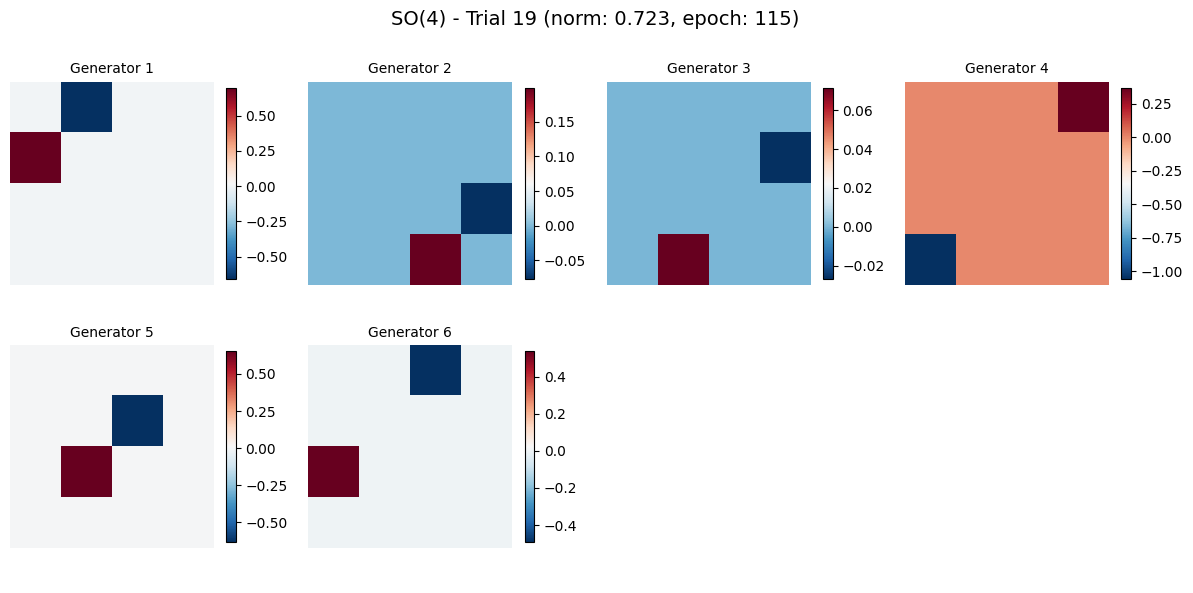


Trial 20/20
 Perturbation (a, b, c, d): a: -1.192, b: -0.210, c: -0.232, d: -0.067
 Metric diagonal: [-0.192, 0.79, 0.768, 0.933]
 Norm of perturbation: 1.2339
    Epoch 5: closure_loss = 2.37e-01
    Epoch 10: closure_loss = 5.20e-03
    Epoch 15: closure_loss = 9.47e-04
    Epoch 20: closure_loss = 1.24e-03
    Epoch 25: closure_loss = 1.76e-03
    Epoch 30: closure_loss = 2.56e-03
    Epoch 35: closure_loss = 2.08e-03
    Epoch 40: closure_loss = 1.93e-03
    Epoch 45: closure_loss = 1.59e-03
    Epoch 50: closure_loss = 8.30e-04
    Epoch 55: closure_loss = 2.22e-03
    Epoch 60: closure_loss = 1.78e-03
    Epoch 65: closure_loss = 1.72e-03
    Epoch 70: closure_loss = 9.34e-04
    Epoch 75: closure_loss = 9.42e-04
    Epoch 80: closure_loss = 9.68e-04
    Epoch 85: closure_loss = 2.10e-03
    Epoch 90: closure_loss = 2.33e-03
    Epoch 95: closure_loss = 2.15e-03
    Epoch 100: closure_loss = 1.37e-03
    Epoch 105: closure_loss = 1.17e-03
    Epoch 110: closure_loss = 1.30e-03
 

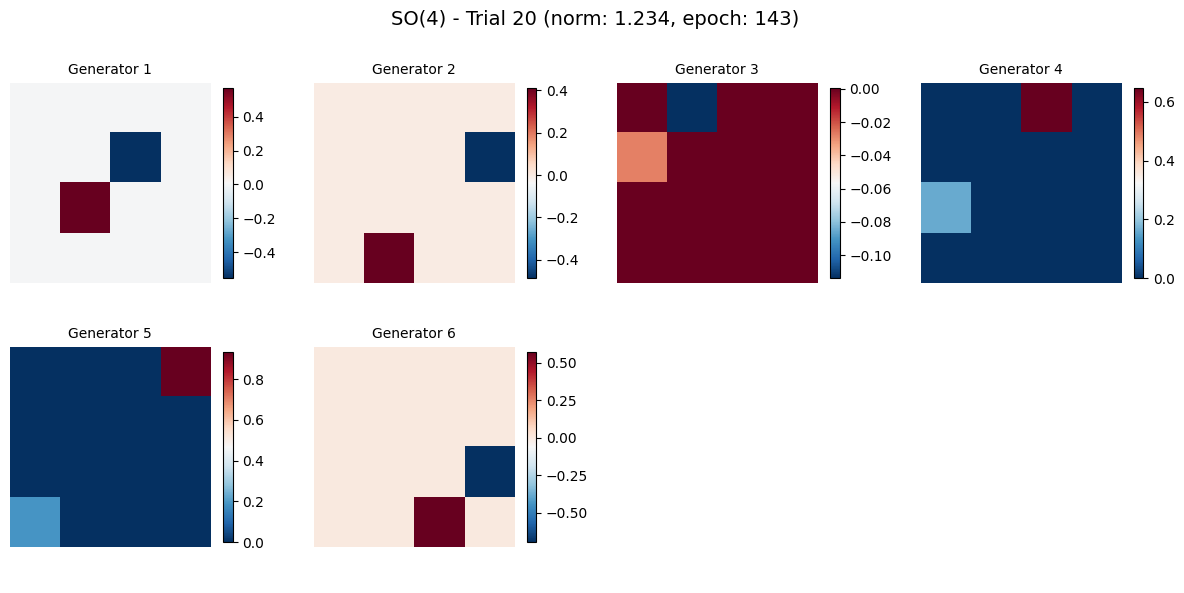


Summary of all trials:
  - Trial 1: Norm = 2.7020, Epochs = 86
  - Trial 2: Norm = 2.4414, Epochs = 124
  - Trial 3: Norm = 2.2211, Epochs = 95
  - Trial 4: Norm = 1.9137, Epochs = 200
  - Trial 5: Norm = 1.7022, Epochs = 143
  - Trial 6: Norm = 2.0501, Epochs = 200
  - Trial 7: Norm = 2.3868, Epochs = 122
  - Trial 8: Norm = 2.1371, Epochs = 15
  - Trial 9: Norm = 3.2146, Epochs = 182
  - Trial 10: Norm = 2.1652, Epochs = 189
  - Trial 11: Norm = 2.2634, Epochs = 200
  - Trial 12: Norm = 2.8518, Epochs = 148
  - Trial 13: Norm = 1.0166, Epochs = 110
  - Trial 14: Norm = 2.3924, Epochs = 97
  - Trial 15: Norm = 2.6364, Epochs = 27
  - Trial 16: Norm = 2.4626, Epochs = 68
  - Trial 17: Norm = 2.7144, Epochs = 119
  - Trial 18: Norm = 2.4716, Epochs = 6
  - Trial 19: Norm = 0.7227, Epochs = 115
  - Trial 20: Norm = 1.2339, Epochs = 143


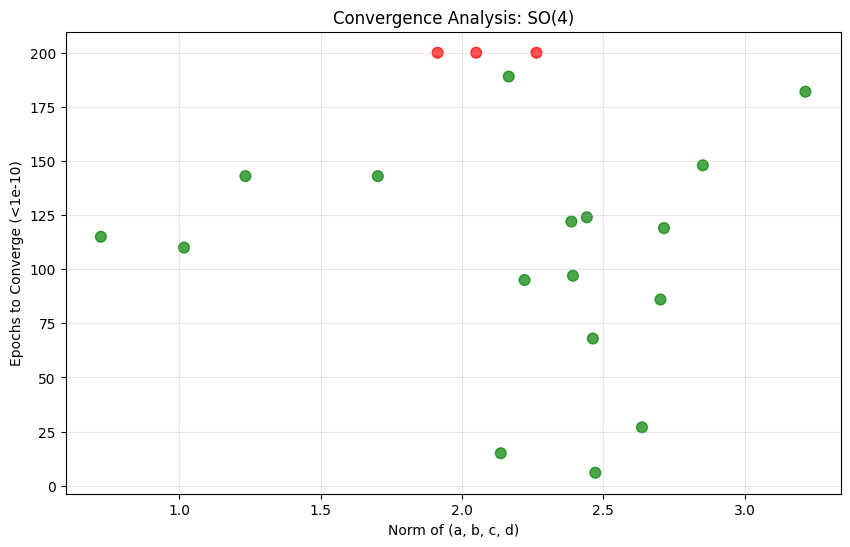

In [ ]:
metric_perturbation_convergence_experiment(
    n=4,
    num_generators=6, 
    data_size=int(1e5),
    batch_size=1024,
    epochs=200, 
    lr=1e-2,
    device="cuda:0",
    num_trials=20
)
